In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.distributions import Categorical

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.25
GAMMA = 0.99
EPS = 1e-8
GRAD_NORM = True

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        q = self.fc(out).reshape(out.shape[0], -1)

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    global action_space
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.to(device).float()
        done_mask = 1 - d.to(device).float()

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            _q_max = torch.max(_q_batch_tgt, dim=1)[0]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = (r_batch + GAMMA * done_mask * _q_max - q_acting).pow(2).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        if GRAD_NORM:
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q)

    return action.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make a memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            with torch.no_grad():
                for t, n in zip(target_net.parameters(), net.parameters()):
                    t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dqn.pt')
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00
  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00

============  Start Learning  ============

  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episo

191 Episode in 34945 steps, reward -156.00
192 Episode in 35067 steps, reward -122.00
193 Episode in 35253 steps, reward -186.00
194 Episode in 35453 steps, reward -200.00
195 Episode in 35653 steps, reward -200.00
196 Episode in 35853 steps, reward -200.00
197 Episode in 36053 steps, reward -200.00
198 Episode in 36253 steps, reward -200.00
199 Episode in 36453 steps, reward -200.00
200 Episode in 36653 steps, reward -200.00
201 Episode in 36853 steps, reward -200.00
202 Episode in 37053 steps, reward -200.00
203 Episode in 37253 steps, reward -200.00
204 Episode in 37453 steps, reward -200.00
205 Episode in 37653 steps, reward -200.00
206 Episode in 37853 steps, reward -200.00
207 Episode in 38053 steps, reward -200.00
208 Episode in 38253 steps, reward -200.00
209 Episode in 38453 steps, reward -200.00
210 Episode in 38653 steps, reward -200.00
211 Episode in 38853 steps, reward -200.00
212 Episode in 39053 steps, reward -200.00
213 Episode in 39253 steps, reward -200.00
214 Episode

382 Episode in 72709 steps, reward -200.00
383 Episode in 72909 steps, reward -200.00
384 Episode in 73109 steps, reward -200.00
385 Episode in 73309 steps, reward -200.00
386 Episode in 73509 steps, reward -200.00
387 Episode in 73709 steps, reward -200.00
388 Episode in 73909 steps, reward -200.00
389 Episode in 74109 steps, reward -200.00
390 Episode in 74309 steps, reward -200.00
391 Episode in 74509 steps, reward -200.00
392 Episode in 74709 steps, reward -200.00
393 Episode in 74909 steps, reward -200.00
394 Episode in 75109 steps, reward -200.00
395 Episode in 75309 steps, reward -200.00
396 Episode in 75509 steps, reward -200.00
397 Episode in 75709 steps, reward -200.00
398 Episode in 75909 steps, reward -200.00
399 Episode in 76109 steps, reward -200.00
400 Episode in 76309 steps, reward -200.00
401 Episode in 76509 steps, reward -200.00
402 Episode in 76709 steps, reward -200.00
403 Episode in 76909 steps, reward -200.00
404 Episode in 77109 steps, reward -200.00
405 Episode

572 Episode in 107927 steps, reward -200.00
573 Episode in 108127 steps, reward -200.00
574 Episode in 108327 steps, reward -200.00
575 Episode in 108527 steps, reward -200.00
576 Episode in 108727 steps, reward -200.00
577 Episode in 108927 steps, reward -200.00
578 Episode in 109127 steps, reward -200.00
579 Episode in 109327 steps, reward -200.00
580 Episode in 109447 steps, reward -120.00
581 Episode in 109647 steps, reward -200.00
582 Episode in 109797 steps, reward -150.00
583 Episode in 109997 steps, reward -200.00
584 Episode in 110193 steps, reward -196.00
585 Episode in 110393 steps, reward -200.00
586 Episode in 110592 steps, reward -199.00
587 Episode in 110792 steps, reward -200.00
588 Episode in 110954 steps, reward -162.00
589 Episode in 111152 steps, reward -198.00
590 Episode in 111321 steps, reward -169.00
591 Episode in 111415 steps, reward -94.00
592 Episode in 111519 steps, reward -104.00
593 Episode in 111695 steps, reward -176.00
594 Episode in 111895 steps, rewa

759 Episode in 143947 steps, reward -200.00
760 Episode in 144147 steps, reward -200.00
761 Episode in 144347 steps, reward -200.00
762 Episode in 144520 steps, reward -173.00
763 Episode in 144644 steps, reward -124.00
764 Episode in 144844 steps, reward -200.00
765 Episode in 145044 steps, reward -200.00
766 Episode in 145237 steps, reward -193.00
767 Episode in 145368 steps, reward -131.00
768 Episode in 145489 steps, reward -121.00
769 Episode in 145655 steps, reward -166.00
770 Episode in 145815 steps, reward -160.00
771 Episode in 145978 steps, reward -163.00
772 Episode in 146178 steps, reward -200.00
773 Episode in 146378 steps, reward -200.00
774 Episode in 146578 steps, reward -200.00
775 Episode in 146778 steps, reward -200.00
776 Episode in 146978 steps, reward -200.00
777 Episode in 147153 steps, reward -175.00
778 Episode in 147353 steps, reward -200.00
779 Episode in 147553 steps, reward -200.00
780 Episode in 147753 steps, reward -200.00
781 Episode in 147927 steps, rew

946 Episode in 179410 steps, reward -200.00
947 Episode in 179571 steps, reward -161.00
948 Episode in 179726 steps, reward -155.00
949 Episode in 179890 steps, reward -164.00
950 Episode in 180060 steps, reward -170.00
951 Episode in 180182 steps, reward -122.00
952 Episode in 180354 steps, reward -172.00
953 Episode in 180554 steps, reward -200.00
954 Episode in 180754 steps, reward -200.00
955 Episode in 180921 steps, reward -167.00
956 Episode in 181121 steps, reward -200.00
957 Episode in 181321 steps, reward -200.00
958 Episode in 181521 steps, reward -200.00
959 Episode in 181721 steps, reward -200.00
960 Episode in 181921 steps, reward -200.00
961 Episode in 182121 steps, reward -200.00
962 Episode in 182311 steps, reward -190.00
963 Episode in 182509 steps, reward -198.00
964 Episode in 182707 steps, reward -198.00
965 Episode in 182837 steps, reward -130.00
966 Episode in 182976 steps, reward -139.00
967 Episode in 183176 steps, reward -200.00
968 Episode in 183375 steps, rew

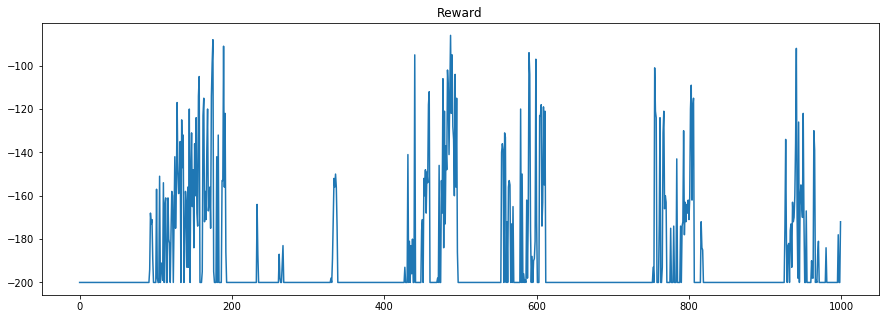

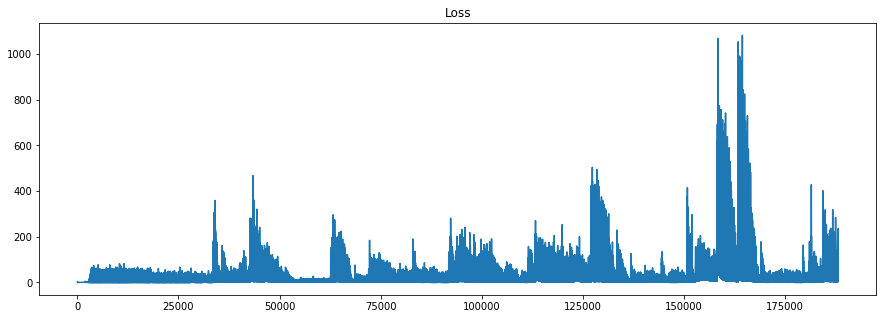

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 207, 0.25),
    ('CartPole-v1', 346, 0.25),
    ('MountainCar-v0', 304, 0.25),
    ('LunarLander-v2', 423, 0.25)
]

[('CartPole-v0', 184, 0.25),
 ('CartPole-v1', 428, 0.25),
 ('MountainCar-v0', 550, 0.25),
 ('LunarLander-v2', 260, 0.25)]